In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# # Getting device
# run_gpu = 0    # 0,1,2,3,...
# dev = 'cuda:' + str(run_gpu)
# # dev='cpu'

# print(torch.cuda.is_available())
# device = torch.device(dev if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))
dev = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
dev

device(type='cpu')

In [3]:
class MLP(torch.nn.Module):
     def __init__(self, input_dim, output_dim, dev='cpu', hidden_dims=[]):
        super(MLP, self).__init__()
        self.linear_set = []
        if len(hidden_dims) == 0:
            self.linear_set.append(torch.nn.Linear(input_dim, output_dim).to(dev))
        else:
            for ilayer in range(len(hidden_dims) + 1):
                if ilayer == 0:
                    dim1 = input_dim
                    dim2 = hidden_dims[0]
                elif ilayer == len(hidden_dims):
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = output_dim
                else:
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = hidden_dims[ilayer]
                self.linear_set.append(torch.nn.Linear(dim1, dim2).to(dev))
#         print(len(self.linear_set))
     def forward(self, x):
        for ilayer in range(len(self.linear_set) - 1):
#             print(ilayer)
            # x = torch.sigmoid(self.linear_set[ilayer](x))

            # Fixed
            x = torch.relu(self.linear_set[ilayer](x))
        outputs = self.linear_set[-1](x)
        return outputs

dim = 2
model = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 5, 5])
# test
model(torch.tensor([1,1], dtype=torch.float32).to(dev))

tensor([ 0.0289, -0.3166], grad_fn=<ViewBackward0>)

## Problem #1


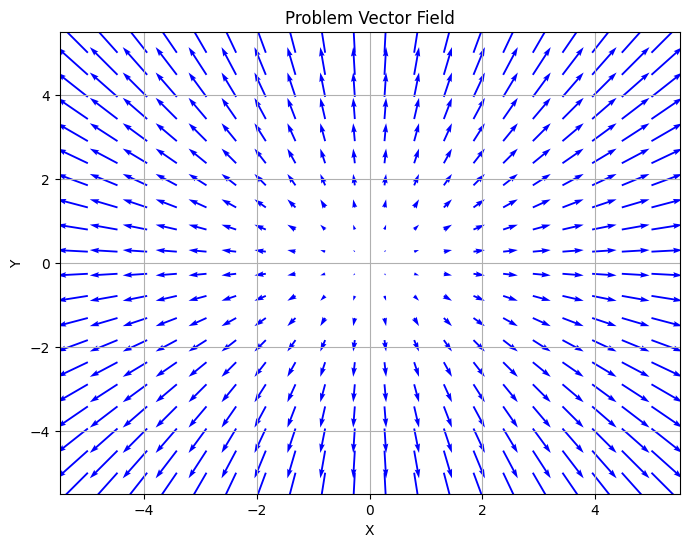

In [4]:
# quiver usage example
# Define the grid
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

# Define vector field function
def vector_field(x, y):
    # Define vector components (you can replace these with any functions)
    u = x*.05
    v = y*.05
#     v = np.zeros_like(y)
    return u, v

# Compute vector components
U, V = vector_field(X, Y)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Problem Vector Field')
plt.grid(True)
plt.show()

In [5]:
losses = []
epochs = 20_000
learning_rate = 0.1
dim = 2

model = MLP(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 10, 5, 5])
params = []
for param_ft in [model.linear_set[i].parameters() for i in range(len(model.linear_set))]:
    for param in param_ft:
#         print(param)
        params.append(param)
optimizer = torch.optim.SGD(params, lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1
    input_model = torch.cat([torch.tensor(X, dtype=torch.float32), \
                torch.tensor(Y, dtype=torch.float32)], \
                axis=1).to(dev)
#     print(input_model.device)

    optimizer.zero_grad() # Setting our stored gradients equal to zero
    output = model(input_model)
    loss_fn = torch.nn.MSELoss()

    U, V = vector_field(X, Y)
    loss = loss_fn(output, torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    losses.append(loss.cpu().detach().numpy().tolist())

print(losses[0:5], losses[-5:-1])
# print(model(input_model))

Training Epochs: 100%|██████████| 20000/20000 [00:14<00:00, 1418.00it/s]

[0.06542477011680603, 0.05701344832777977, 0.05025361105799675, 0.04481726512312889, 0.040442775934934616] [2.5973236915888265e-05, 2.5971201466745697e-05, 2.59691514656879e-05, 2.5967126930481754e-05]


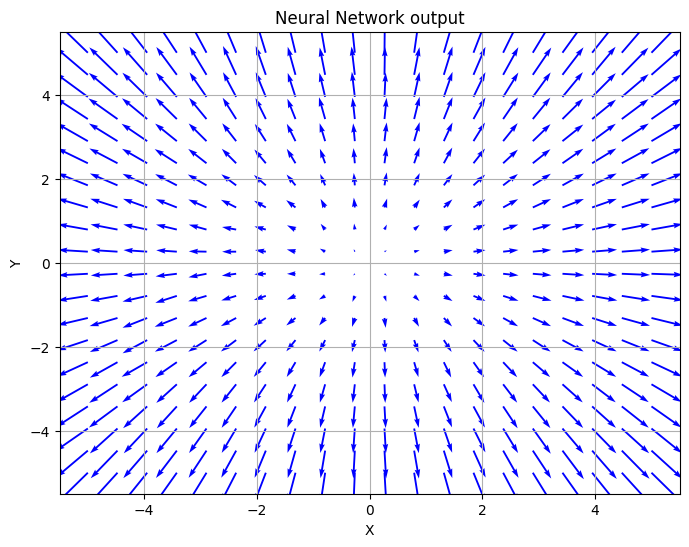

In [6]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
input_data = np.concatenate([X.reshape([-1,1]), Y.reshape([-1,1])], axis=1)  # 20^2 x 2
output_data = model(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Neural Network output')
plt.grid(True)
plt.show()

What is the problem? Can you fix it?

## Problem #2

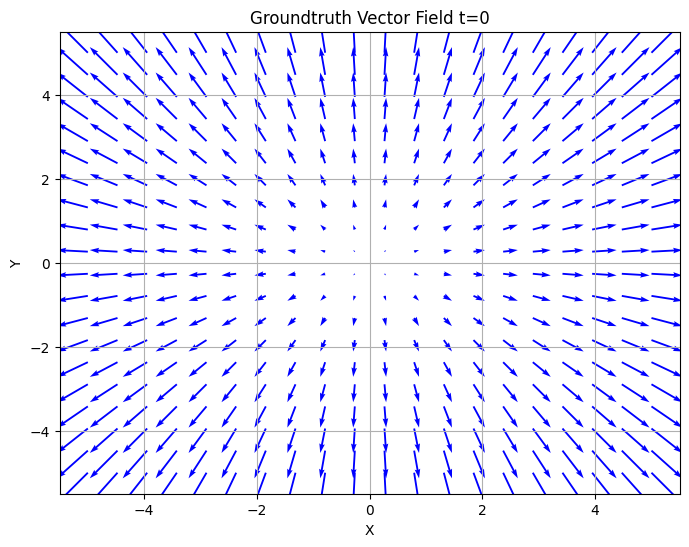

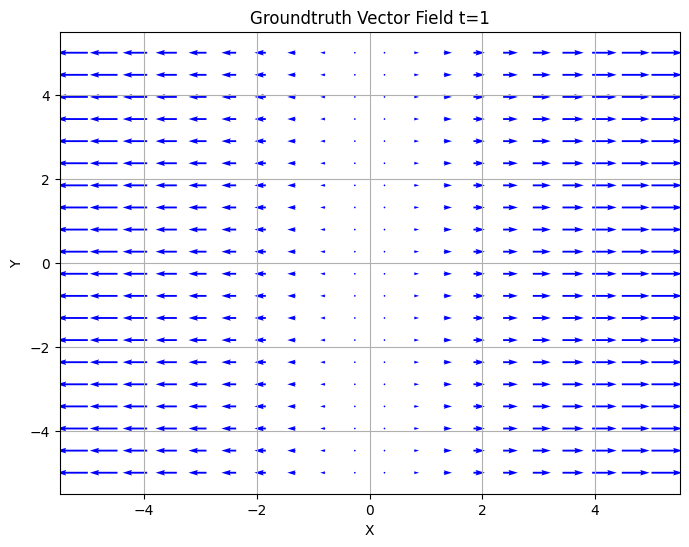

In [7]:
# Define vector field function
def vector_field(x, y, t):
    # Define vector components (you can replace these with any functions)
    u = x*.05
    if t == 0:
        v = y*.05
    else:
        v = np.zeros_like(y)
    return u, v


# quiver usage example
# Define the grid
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

# Compute vector components
U, V = vector_field(X, Y, t=0)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Groundtruth Vector Field t=0')
plt.grid(True)
plt.show()

# Compute vector components
U, V = vector_field(X, Y, t=1)

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Groundtruth Vector Field t=1')
plt.grid(True)
plt.show()


In [9]:
class MLP2(torch.nn.Module):
     def __init__(self, input_dim, output_dim, dev='cpu', hidden_dims=[]):
        super(MLP2, self).__init__()
        self.linear_set = []
        if len(hidden_dims) == 0:
            self.linear_set.append(torch.nn.Linear(input_dim, output_dim).to(dev))
        else:
            for ilayer in range(len(hidden_dims) + 1):
                if ilayer == 0:
                    dim1 = input_dim
                    dim2 = hidden_dims[0]
                elif ilayer == len(hidden_dims):
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = output_dim
                else:
                    dim1 = hidden_dims[ilayer-1]
                    dim2 = hidden_dims[ilayer]
                self.linear_set.append(torch.nn.Linear(dim1, dim2).to(dev))
            self.linear_set = torch.nn.ModuleList(self.linear_set)
#         print(len(self.linear_set))
     def forward(self, x):
        for ilayer in range(len(self.linear_set) - 1):
            # x = torch.sigmoid(self.linear_set[ilayer](x))
            x = torch.relu(self.linear_set[ilayer](x))
        outputs = self.linear_set[-1](x)
        return outputs

dim = 2
model = MLP2(input_dim=dim, output_dim=dim, dev=dev, hidden_dims=[10, 5, 5])
# test
model(torch.tensor([1,1], dtype=torch.float32).to(dev))

tensor([-0.0793, -0.2233], grad_fn=<ViewBackward0>)

In [10]:
losses = []
epochs = 50_000
# learning_rate = 0.01
learning_rate = 0.1
dim = 2

spacetime_dim = dim + 1
model = MLP2(input_dim=spacetime_dim, output_dim=dim, \
            dev=dev, hidden_dims=[50, 10, 5, 5]).to(dev)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# time_step = 1.
time_step = 10
# time_step = 5


for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    X = X.reshape([-1,1])   # 20^2 x 1
    Y = Y.reshape([-1,1])   # 20^2 x 1
    frame=0
    input_model1 = torch.cat([torch.tensor(X, device=dev, dtype=torch.float32), \
                torch.tensor(Y, device=dev, dtype=torch.float32), \
                time_step*frame*torch.ones(len(X),1, device=dev, dtype=torch.float32)], \
                axis=1)
    U1, V1 = vector_field(X, Y, t=frame)

    frame=1
    input_model2 = torch.cat([torch.tensor(X, device=dev, dtype=torch.float32), \
                torch.tensor(Y, device=dev, dtype=torch.float32), \
                time_step*frame*torch.ones(len(X),1, device=dev, dtype=torch.float32)], \
                axis=1)

    U2, V2 = vector_field(X, Y, t=frame)

    input_model = torch.cat([input_model1, input_model2])
    U = np.concatenate([U1, U2])
    V = np.concatenate([V1, V2])

    optimizer.zero_grad() # Setting our stored gradients equal to zero
    output = model(input_model)
    loss_fn = torch.nn.MSELoss()

    loss = loss_fn(output, \
                   torch.tensor(np.concatenate([U, V], axis=1), device=dev, dtype=torch.float32))
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    losses.append(loss.cpu().detach().numpy().tolist())

print(losses[0:5], losses[-5:-1])
# print(model(input_model))

Training Epochs: 100%|██████████| 50000/50000 [00:49<00:00, 1008.78it/s]

[0.1634470820426941, 0.1099448874592781, 0.07689092308282852, 0.056729692965745926, 0.04442515969276428] [5.833396699017612e-06, 5.833290742884856e-06, 5.833192062709713e-06, 5.833093382534571e-06]


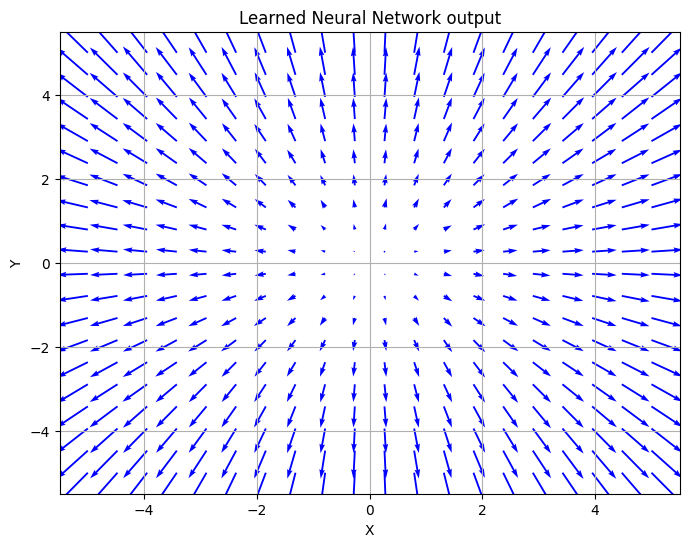

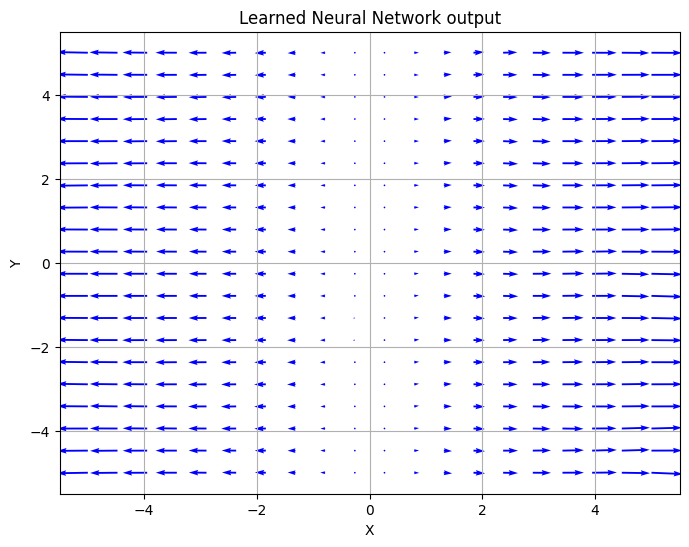

In [11]:
x = np.linspace(-5, 5, 20)
y = np.linspace(-5, 5, 20)
X, Y = np.meshgrid(x, y)   # 20x20, 20x20
X = X.reshape([-1,1])   # 20^2 x 1
Y = Y.reshape([-1,1])   # 20^2 x 1

frame = 0
input_data = np.concatenate([X, Y, time_step*frame*np.ones_like(X)], axis=1)  # 20^2 x 2
# input_data = np.concatenate([X, Y], axis=1)  # 20^2 x 2
output_data = model(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Learned Neural Network output')
plt.grid(True)
plt.show()

frame = 1
input_data = np.concatenate([X, Y, time_step*frame*np.ones_like(X)], axis=1)  # 20^2 x 2
# input_data = np.concatenate([X, Y], axis=1)  # 20^2 x 2
output_data = model(torch.tensor(input_data, device=dev, dtype=torch.float32))
# output_data
U = output_data.cpu().detach().numpy()[:,0].reshape([20,20])
V = output_data.cpu().detach().numpy()[:,1].reshape([20,20])

# Plot the vector field
plt.figure(figsize=(8, 6))
plt.quiver(X, Y, U, V, scale=5, color='blue', width=0.003)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Learned Neural Network output')
plt.grid(True)
plt.show()

The result is not satisfactory. Can you improve it?